In [1]:
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn import cluster
from sklearn import model_selection
from sklearn import neural_network

/home/user/opt/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.options.display.width = 200
pd.options.display.max_columns = 50

In [3]:
train = pd.read_csv('../data/in/train.csv', delimiter=';')
test = pd.read_csv('../data/in/test.csv', delimiter=';')
y = train.cardio
train.drop('cardio', axis=1, inplace=True)

In [4]:
test['alco'].replace('None', 0, inplace=True)
test['smoke'].replace('None', 0, inplace=True)
test['active'].replace('None', 1, inplace=True)

In [5]:
y = y.astype('float32')
train = train.astype('float32')
test = test.astype('float32')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
id             30000 non-null float32
age            30000 non-null float32
gender         30000 non-null float32
height         30000 non-null float32
weight         30000 non-null float32
ap_hi          30000 non-null float32
ap_lo          30000 non-null float32
cholesterol    30000 non-null float32
gluc           30000 non-null float32
smoke          30000 non-null float32
alco           30000 non-null float32
active         30000 non-null float32
dtypes: float32(12)
memory usage: 1.4 MB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
id             70000 non-null float32
age            70000 non-null float32
gender         70000 non-null float32
height         70000 non-null float32
weight         70000 non-null float32
ap_hi          70000 non-null float32
ap_lo          70000 non-null float32
cholesterol    70000 non-null float32
gluc           70000 non-null float32
smoke          70000 non-null float32
alco           70000 non-null float32
active         70000 non-null float32
dtypes: float32(12)
memory usage: 3.2 MB


In [7]:
train['y'] = y
train['train'] = 1
test['y'] = -1
test['train'] = 0
df_all = pd.concat([train, test]).astype('float32')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 29999
Data columns (total 14 columns):
id             100000 non-null float32
age            100000 non-null float32
gender         100000 non-null float32
height         100000 non-null float32
weight         100000 non-null float32
ap_hi          100000 non-null float32
ap_lo          100000 non-null float32
cholesterol    100000 non-null float32
gluc           100000 non-null float32
smoke          100000 non-null float32
alco           100000 non-null float32
active         100000 non-null float32
y              100000 non-null float32
train          100000 non-null float32
dtypes: float32(14)
memory usage: 6.1 MB


In [8]:
idx_ap_hi = (df_all.ap_hi > 240).values | (df_all.ap_hi < 60).values
idx_ap_lo = (df_all.ap_lo > 160).values | (df_all.ap_lo < 30).values
idx_weight = (df_all.weight > 180).values | (df_all.weight < 35).values
idx_height = (df_all.height > 210).values | (df_all.height < 130).values

idx = (idx_ap_hi + idx_ap_lo + idx_weight + idx_height > 0) * (df_all.train == 1).values
df2 = df_all[~idx].copy()

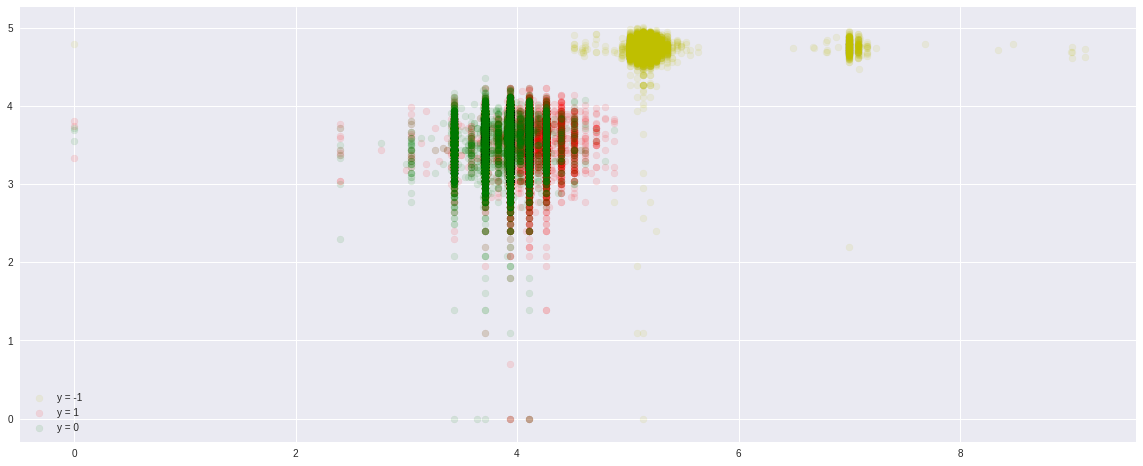

In [9]:
axn = 'ap_lo'
ayn = 'height'
axf = lambda x: np.log1p(x - x.min())
ayf = lambda x: np.log1p(x - x.min())

order = [
    (-1, 'y'),
    ( 1, 'r'),
    ( 0, 'g'),
]

plot.figure(figsize=(20,8))
for val, col in order:
    idx = (df2.y == val).values
    plot.scatter(axf(df2.ix[idx, axn]), ayf(df2.ix[idx, ayn]), c=col, alpha=0.1, label='y = ' + str(val))
plot.legend()
plot.show()

In [10]:
train = df2[df2.train == 1]
test = df2[df2.train == 0]
y = df2.ix[df2.train == 1, 'y'].values.ravel()
train.shape, test.shape

((68661, 14), (30000, 14))

In [11]:
train.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,y,train
count,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.000000,68661.0
mean,49969.667969,19464.804688,1.348728,164.439987,74.117027,126.617981,81.363945,1.364865,1.225994,0.088056,0.053611,0.803455,0.494881,1.0
std,28846.296875,2467.874756,0.476571,7.846304,14.259059,16.753876,9.603820,0.679068,0.571972,0.283378,0.225251,0.397388,0.499977,0.0
min,0.000000,10798.000000,1.000000,130.000000,35.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,24996.000000,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0
50%,50010.000000,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0
75%,74860.000000,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,99999.000000,23713.000000,2.000000,207.000000,180.000000,240.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [18]:
xgb_params = dict(
    learning_rate = 0.02,
    max_depth = 5,
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    seed = 1,
    silent = 1
    )

In [13]:
dtrain = xgb.DMatrix(train.drop(['y', 'train'], axis=1), y)
cv = xgb.cv(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=20, nfold=10, seed=1)
cv

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.687873,0.000119,0.687830,0.000024
1,0.682810,0.000233,0.682721,0.000048
2,0.677944,0.000346,0.677813,0.000070
3,0.673262,0.000455,0.673093,0.000092
4,0.668765,0.000561,0.668555,0.000112
5,0.664435,0.000668,0.664189,0.000131
6,0.660277,0.000766,0.659987,0.000151
7,0.656272,0.000871,0.655944,0.000169
8,0.652414,0.000969,0.652051,0.000187
9,0.648698,0.001072,0.648301,0.000204


In [14]:
baseline_cv = cv.ix[len(cv)-1, 0]

train2 = train.drop(['y', 'train'], axis=1)
for c in train2.columns: train2[c] = (train2[c] - train2[c].min()) + 1
h = train.height / 100
t3 = pd.DataFrame()

t3['ap.hi greater than 200'] = (train.ap_hi > 200) * 1 #
t3['ap.hi less than 70'] = (train.ap_hi < 70) * 1 #

t3['ap.lo greater than 160'] = (train.ap_lo > 160) * 1 #
t3['ap.lo less than 40'] = (train.ap_lo < 40) * 1 #

t3['h - w'] = train.height - train.weight # 

t3['w / h'] = train.weight / h # 
t3['w / h^2'] = train.weight / h / h # 
t3['w / h^3'] = train.weight / h / h / h # 

t3['ap: hi - lo'] = train.ap_hi - train.ap_lo # 
t3['ap: hi / lo'] = train2.ap_hi / train2.ap_lo # 

t3['height - ap_lo'] = train.height - train.ap_lo # 
t3['weight - ap_lo'] = train.weight - train.ap_lo # 

t3['height - ap_hi'] = train.height - train.ap_hi # 
t3['weight - ap_hi'] = train.weight - train.ap_hi # 

names = []
scores = []

t3 = t3.astype('float32')
for c in t3.columns:
    dtrain = xgb.DMatrix(pd.concat([train2, t3[c]], axis=1), y)
    cv = xgb.cv(xgb_params, dtrain, num_boost_round=10000, early_stopping_rounds=20, nfold=10, seed=1)
    names.append(c)
    scores.append(cv.ix[len(cv)-1, 0])
    print(names[-1], scores[-1], scores[-1] - baseline_cv)

df = pd.DataFrame({'features' : names, 'scores' : scores})
df['gain'] = df.scores - baseline_cv
df['good'] = df.scores < baseline_cv
df.sort_values('gain', ascending=True, inplace=True)
df

ap.hi greater than 200 0.5405235 0.0
ap.hi less than 70 0.5405235 0.0
ap.lo greater than 160 0.5405235 0.0
ap.lo less than 40 0.5405235 0.0
w / h 0.5404543 -6.92e-05
h - w 0.5404663 -5.72e-05
w / h^2 0.5405716 4.81000000001e-05
w / h^3 0.5406225 9.9e-05
ap: hi - lo 0.5407632 0.0002397
ap: hi / lo 0.5407502 0.0002267
height - ap_lo 0.5406135 9e-05
weight - ap_lo 0.5406964 0.0001729
height - ap_hi 0.5406296 0.0001061
weight - ap_hi 0.5405286 5.10000000009e-06


,features,scores,gain,good
4,w / h,0.540454,-0.000069,True
5,h - w,0.540466,-0.000057,True
0,ap.hi greater than 200,0.540523,0.000000,False
1,ap.hi less than 70,0.540523,0.000000,False
2,ap.lo greater than 160,0.540523,0.000000,False
3,ap.lo less than 40,0.540523,0.000000,False
13,weight - ap_hi,0.540529,0.000005,False
6,w / h^2,0.540572,0.000048,False
10,height - ap_lo,0.540613,0.000090,False
7,w / h^3,0.540622,0.000099,False


In [15]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68661 entries, 0 to 69999
Data columns (total 12 columns):
id             68661 non-null float32
age            68661 non-null float32
gender         68661 non-null float32
height         68661 non-null float32
weight         68661 non-null float32
ap_hi          68661 non-null float32
ap_lo          68661 non-null float32
cholesterol    68661 non-null float32
gluc           68661 non-null float32
smoke          68661 non-null float32
alco           68661 non-null float32
active         68661 non-null float32
dtypes: float32(12)
memory usage: 3.7 MB


In [16]:
print('done.')

done.
